In [1]:
import pandas as pd
import xgboost as xgb
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # For logging values within training loop
import torch.onnx
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Load dataset
df = pd.read_csv('AmazonDataSales_v2.csv', low_memory=False)
# Drop all columns except 'amount', 'category', 'size', 'quantity'
df = df[['amount', 'category', 'size', 'qty']]

# One-hot encode the 'category', 'size', and 'qty' columns
# Select all columns except 'amount' as feature columns
feature_columns = df.columns.drop('amount')
# One-hot encode the feature columns
df_encoded = pd.get_dummies(df, columns=feature_columns)

# Assuming 'df' contains your dataset
X = df_encoded.drop('amount', axis=1)  # Features
y = df['amount']  # Target

#Network stopped converging, the only things I did was add hooks and remove this line
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Convert to numpy arrays (required for PyTorch tensors)
X_np = np.array(X, dtype=np.float32)
y_np = np.array(y, dtype=np.float32)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_np)
y_tensor = torch.tensor(y_np)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Logging during training
writer = SummaryWriter()

In [6]:
# Function to register hooks for monitoring activations
def register_activation_hooks(model, writer):
    def hook_fn(module, input, output):
        writer.add_histogram(f"{module.__class__.__name__}_activations", output)

    for layer in model.modules():
        if isinstance(layer, torch.nn.modules.Linear):
            # Use a closure to capture the current layer
            layer.register_forward_hook(lambda module, input, output, layer=layer: hook_fn(layer, input, output))


# Function to register hooks for monitoring gradients
def register_gradient_hooks(model, writer):
    for name, parameter in model.named_parameters():
        def hook(grad, name=name):  # Capture current value of name
            writer.add_histogram(f"{name}_gradients", grad)
        parameter.register_hook(hook)


# Function to log weights, needs no fancy hooks
def log_weights(model, writer, epoch):
    for name, param in model.named_parameters():
        writer.add_histogram(f"{name}_weights", param, epoch)


In [7]:
class FeedForwardRegressor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(FeedForwardRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer for regression

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Model instantiation and move to device
input_size = X_train.shape[1]
hidden_size1 = 2
hidden_size2 = 2
model = FeedForwardRegressor(input_size, hidden_size1, hidden_size2).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [8]:
#Training function with logging

def train_model(model, train_loader, criterion, optimizer, writer, num_epochs=10):
    model.train()
    register_activation_hooks(model, writer)  # Register activation hooks // register_forward_hook
    register_gradient_hooks(model, writer)     # Register gradient hooks


    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Move data to the device
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Log weights and gradients for the first batch in each epoch
            if batch_idx == 0:
                for name, param in model.named_parameters():
                    writer.add_histogram(f"{name}_weights", param, epoch) #parameter_hook
                    writer.add_histogram(f"{name}_grads", param.grad, epoch) #?_hook

            # Log weights at the end of each epoch
            log_weights(model, writer, epoch)

        # Log loss at each epoch
        writer.add_scalar('Loss/train', total_loss/len(train_loader), epoch)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

In [9]:
# Evaluation function

def evaluate_model(model, test_loader):
    model.eval()
    targets_list = []
    outputs_list = []
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_loader:
            # Move data to the device
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))  # Add an extra dimension to targets

            total_loss += loss.item()
            targets_list.append(targets.cpu())
            outputs_list.append(outputs.cpu())
        
        # Concatenate all batches
        all_targets = torch.cat(targets_list, dim=0)
        all_outputs = torch.cat(outputs_list, dim=0)

        # Calculate R-squared score
        r2 = r2_score(all_targets.numpy(), all_outputs.numpy())
        
        print(f'Test Loss: {total_loss/len(test_loader)}')
        print(f'R-squared: {r2}')

In [10]:
# Run training
train_model(model, train_loader, criterion, optimizer, writer, num_epochs=50)

Epoch 1/50, Loss: 451506.14722664544
Epoch 2/50, Loss: 445848.8184049894
Epoch 3/50, Loss: 413662.6376061571
Epoch 4/50, Loss: 346259.8779856688
Epoch 5/50, Loss: 257315.6859739915
Epoch 6/50, Loss: 169328.47828755307
Epoch 7/50, Loss: 104600.48279093683
Epoch 8/50, Loss: 70309.2998938429
Epoch 9/50, Loss: 56732.71293623938
Epoch 10/50, Loss: 51238.70656681263
Epoch 11/50, Loss: 47972.44153065287
Epoch 12/50, Loss: 45426.18652136412
Epoch 13/50, Loss: 43257.94373673036
Epoch 14/50, Loss: 41379.18443554273
Epoch 15/50, Loss: 39804.26276373408
Epoch 16/50, Loss: 38483.77255009289
Epoch 17/50, Loss: 37482.1471976181
Epoch 18/50, Loss: 36696.601603967625
Epoch 19/50, Loss: 36147.696104531584
Epoch 20/50, Loss: 35847.92718285562
Epoch 21/50, Loss: 35622.790497279726
Epoch 22/50, Loss: 35487.01972200106
Epoch 23/50, Loss: 35392.13826134554
Epoch 24/50, Loss: 35329.9703299164
Epoch 25/50, Loss: 35246.95300889066
Epoch 26/50, Loss: 35193.15229813562
Epoch 27/50, Loss: 35166.1226736664
Epoch 28

In [11]:
# and evaluation
evaluate_model(model, test_loader) 

Test Loss: 35294.09788797669
R-squared: 0.42071745239018354


In [12]:
# How many features or inputs do the model receive 
input_size = X_train.shape[1]
print(input_size)

24


In [13]:
from torchsummary import summary
summary(model, input_size=(input_size,)) # The , after input_size needs to be there

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]              50
              ReLU-2                    [-1, 2]               0
            Linear-3                    [-1, 2]               6
              ReLU-4                    [-1, 2]               0
            Linear-5                    [-1, 1]               3
Total params: 59
Trainable params: 59
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [14]:
# Assuming model is already trained and available

# Create a dummy input tensor matching the input size (batch_size, input_features)
# It's important for the dummy input to have the same type (float) and device (CPU/GPU) as the real inputs
dummy_input = torch.randn(1, input_size, device=device)

# Set the model to evaluation mode
model.eval()

# Export the model to ONNX format
onnx_model_path = "exp6_model.onnx"  # Specify the path to save the ONNX model
torch.onnx.export(model, dummy_input, onnx_model_path, 
                  export_params=True, 
                  opset_version=10, 
                  do_constant_folding=True, 
                  input_names = ['input'], 
                  output_names = ['output'])

print(f"Model saved in ONNX format at {onnx_model_path}")


Model saved in ONNX format at exp6_model.onnx


In [15]:
#Function for plotting Residuals
residual_outliers =[]

def evaluate_model_and_plot_residuals(model, test_loader, df_original):
    model.eval()
    targets_list = []
    outputs_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets_list.append(targets.cpu())
            outputs_list.append(outputs.cpu())

    all_targets = torch.cat(targets_list, dim=0).numpy()
    all_outputs = torch.cat(outputs_list, dim=0).numpy()

    # Calculate R-squared score
    r2 = r2_score(all_targets, all_outputs)
    print(f'R-squared: {r2}')

    # Calculate residuals
    residuals = all_targets - all_outputs.squeeze()

    # Plot residuals
    plt.scatter(all_outputs, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs. Predicted Values')
    plt.show()
    # Assuming residuals is a numpy array of your model's residuals
    residuals = all_targets - all_outputs.squeeze()

    # Durbin-Watson Test
    #durbin_watson = stats.durbin_watson(residuals)
    #print(f'Durbin-Watson: {durbin_watson}')

    # Shapiro-Wilk Test for normality
    shapiro_test = stats.shapiro(residuals)
    print(f'Shapiro-Wilk Test: Statistic={shapiro_test[0]}, p-value={shapiro_test[1]}')

    # Identify outliers based on residuals
    threshold = np.percentile(np.abs(residuals), 95)  # You can adjust this threshold
    outlier_indices = np.where(np.abs(residuals) > threshold)[0]
    outliers_info = df_original.iloc[outlier_indices]

    # Here you can print out the outliers, or return them to analyze further
    print("Outliers based on residuals:")
    print(outliers_info)

    return outliers_info, residuals, all_targets, all_outputs


R-squared: 0.42071745239018354


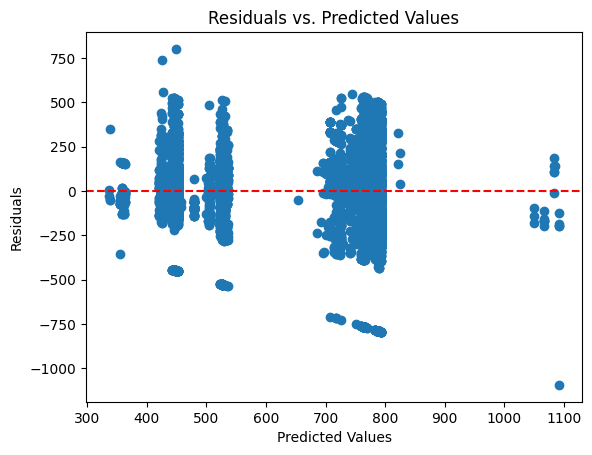

Shapiro-Wilk Test: Statistic=0.9402041703262329, p-value=4.0783499214157056e-69
Outliers based on residuals:
       amount category size  qty
1       406.0    kurta  3xl    1
89      696.0      set    m    1
97      788.0      set    l    1
119     790.0      set    s    1
159     568.0      set   xs    1
...       ...      ...  ...  ...
23403   357.0    kurta    m    1
23450   459.0    kurta    m    1
23453   295.0    kurta    l    1
23458     0.0      set  3xl    1
23469   635.0    kurta    l    1

[1176 rows x 4 columns]


C:\Users\Tono\AppData\Local\Temp\ipykernel_12280\1318030946.py:40: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23516.
  shapiro_test = stats.shapiro(residuals)


In [16]:
outliers_info_df, residuals, all_targets, all_outputs = evaluate_model_and_plot_residuals(model, test_loader, df)